In [26]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../main/')
from multi_py.multi import *
import numpy as np
import sys  
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy.io import readsav
import copy
import pandas as pd
import os
from scipy import integrate
from scipy.signal import argrelextrema
from scipy import interpolate
import pickle
import scipy.constants

%config InlineBackend.figure_format='png'
plt.style.use('default')
plt.style.use('../main/multi_py/Bergemann2020.mplstyle')

## Read in observed spectrum

In [27]:
sav_fname = pjoin('../../data/spectra/1631885174310_iag_sun_Si.sav')
sav_data = readsav(sav_fname)
# f = open('../../data/spectra/sun_kpnomu1_6000_8000A.txt')
# obs_spec2 = np.loadtxt(fname=f)
# f.close()

In [28]:
# simulation has been run with mus: 1, 0.9, 0.8, 0.6, 0.4, 0.2
# specify the indecies corresponding to these angles in the solar data
sol_mu_ind = [0, 4, 5, 7, 9, 11]
# get the flux(intensity) and wavelengths corresponding to these angles
sol_fluxes_raw = [sav_data['iag_sun'].flux[0][ang] for ang in sol_mu_ind]
sol_lams_raw = [sav_data['iag_sun'].wave[0][ang] for ang in sol_mu_ind]
sol_mus = [sav_data['iag_sun'].mu[0][ang] for ang in sol_mu_ind]

major_krs = [286, 291, 293, 299, 427] # 292 and 302 removed - empty gaps; 457 removed - does not appear in the ref paper
m3d_centre_wavelengths = [5645.613, 5684.484, 5701.104, 5772.146, 7034.901]

In [29]:
# remove duplicate values from the spectra 
sol_fluxes=[]
sol_lams=[]

for sm, sol_lam_mu in enumerate(sol_lams_raw):
    unique_sol_lam_inds = np.unique(sol_lam_mu, return_index=True)[-1]
    sol_lams.append(sol_lam_mu[unique_sol_lam_inds])
    sol_fluxes.append((sol_fluxes_raw[sm])[unique_sol_lam_inds])

## Calculate EWs for the observed spectra

In [69]:
# define the integration limits for the iag observed solar spectrum for each line (keep same across angles)
# iag_int_lims = np.array([[5645.4, 5645.8],[5684.31,5684.7],[5700.97,5701.3],[5771.9,5772.35],[7034.55,7035.2]])
# change limit for line at 5701 å
iag_int_lims = np.array([[5645.4, 5645.8],[5684.31,5684.7],[5700.9,5701.3],[5771.9,5772.35],[7034.55,7035.2]])

# Test making integration limits that match the qmax=3.5 km/s used for the simulated lines.
max_int_lims = []
sim_qmax=5
for cw in m3d_centre_wavelengths:
    wav_max = cw * sim_qmax / (scipy.constants.c / 1e3)
    # wav_mask =  np.abs(sol_lams[0]) < wav_max
    # masked_lams = (sol_lams[0])[wav_mask]
    max_int_lims.append([cw-wav_max, cw+wav_max]) 
max_int_lims = np.array(max_int_lims)


In [70]:
max_int_lims

array([[5645.51884131, 5645.70715869],
       [5684.38919301, 5684.57880699],
       [5701.00891582, 5701.19908418],
       [5772.04973097, 5772.24226903],
       [7034.78367048, 7035.01832952]])

In [71]:
eq_iag = np.zeros((len(major_krs), len(sol_mu_ind)))
sol_lam_range_list = np.zeros((len(major_krs), len(sol_mu_ind)), dtype=object)
sol_int_range_list = np.zeros((len(major_krs), len(sol_mu_ind)), dtype=object)
for i, line in enumerate(major_krs):
    line_lammin, line_lammax = iag_int_lims[i]
    for j, mu in enumerate(sol_mu_ind):
        lam_range = sol_lams[j][np.logical_and((sol_lams[j] > line_lammin), (sol_lams[j] < line_lammax))]
        intensity_range = sol_fluxes[j][np.logical_and((sol_lams[j] > line_lammin), (sol_lams[j] < line_lammax))]
        eq_iag[i,j] = integrate.simps(y=1-intensity_range, x=lam_range) * 1000
        # record the wavelengths and intensities corresponding to each line
        sol_lam_range_list[i,j] = lam_range
        sol_int_range_list[i,j] = intensity_range

## Plot zoomed-out observed spectra 

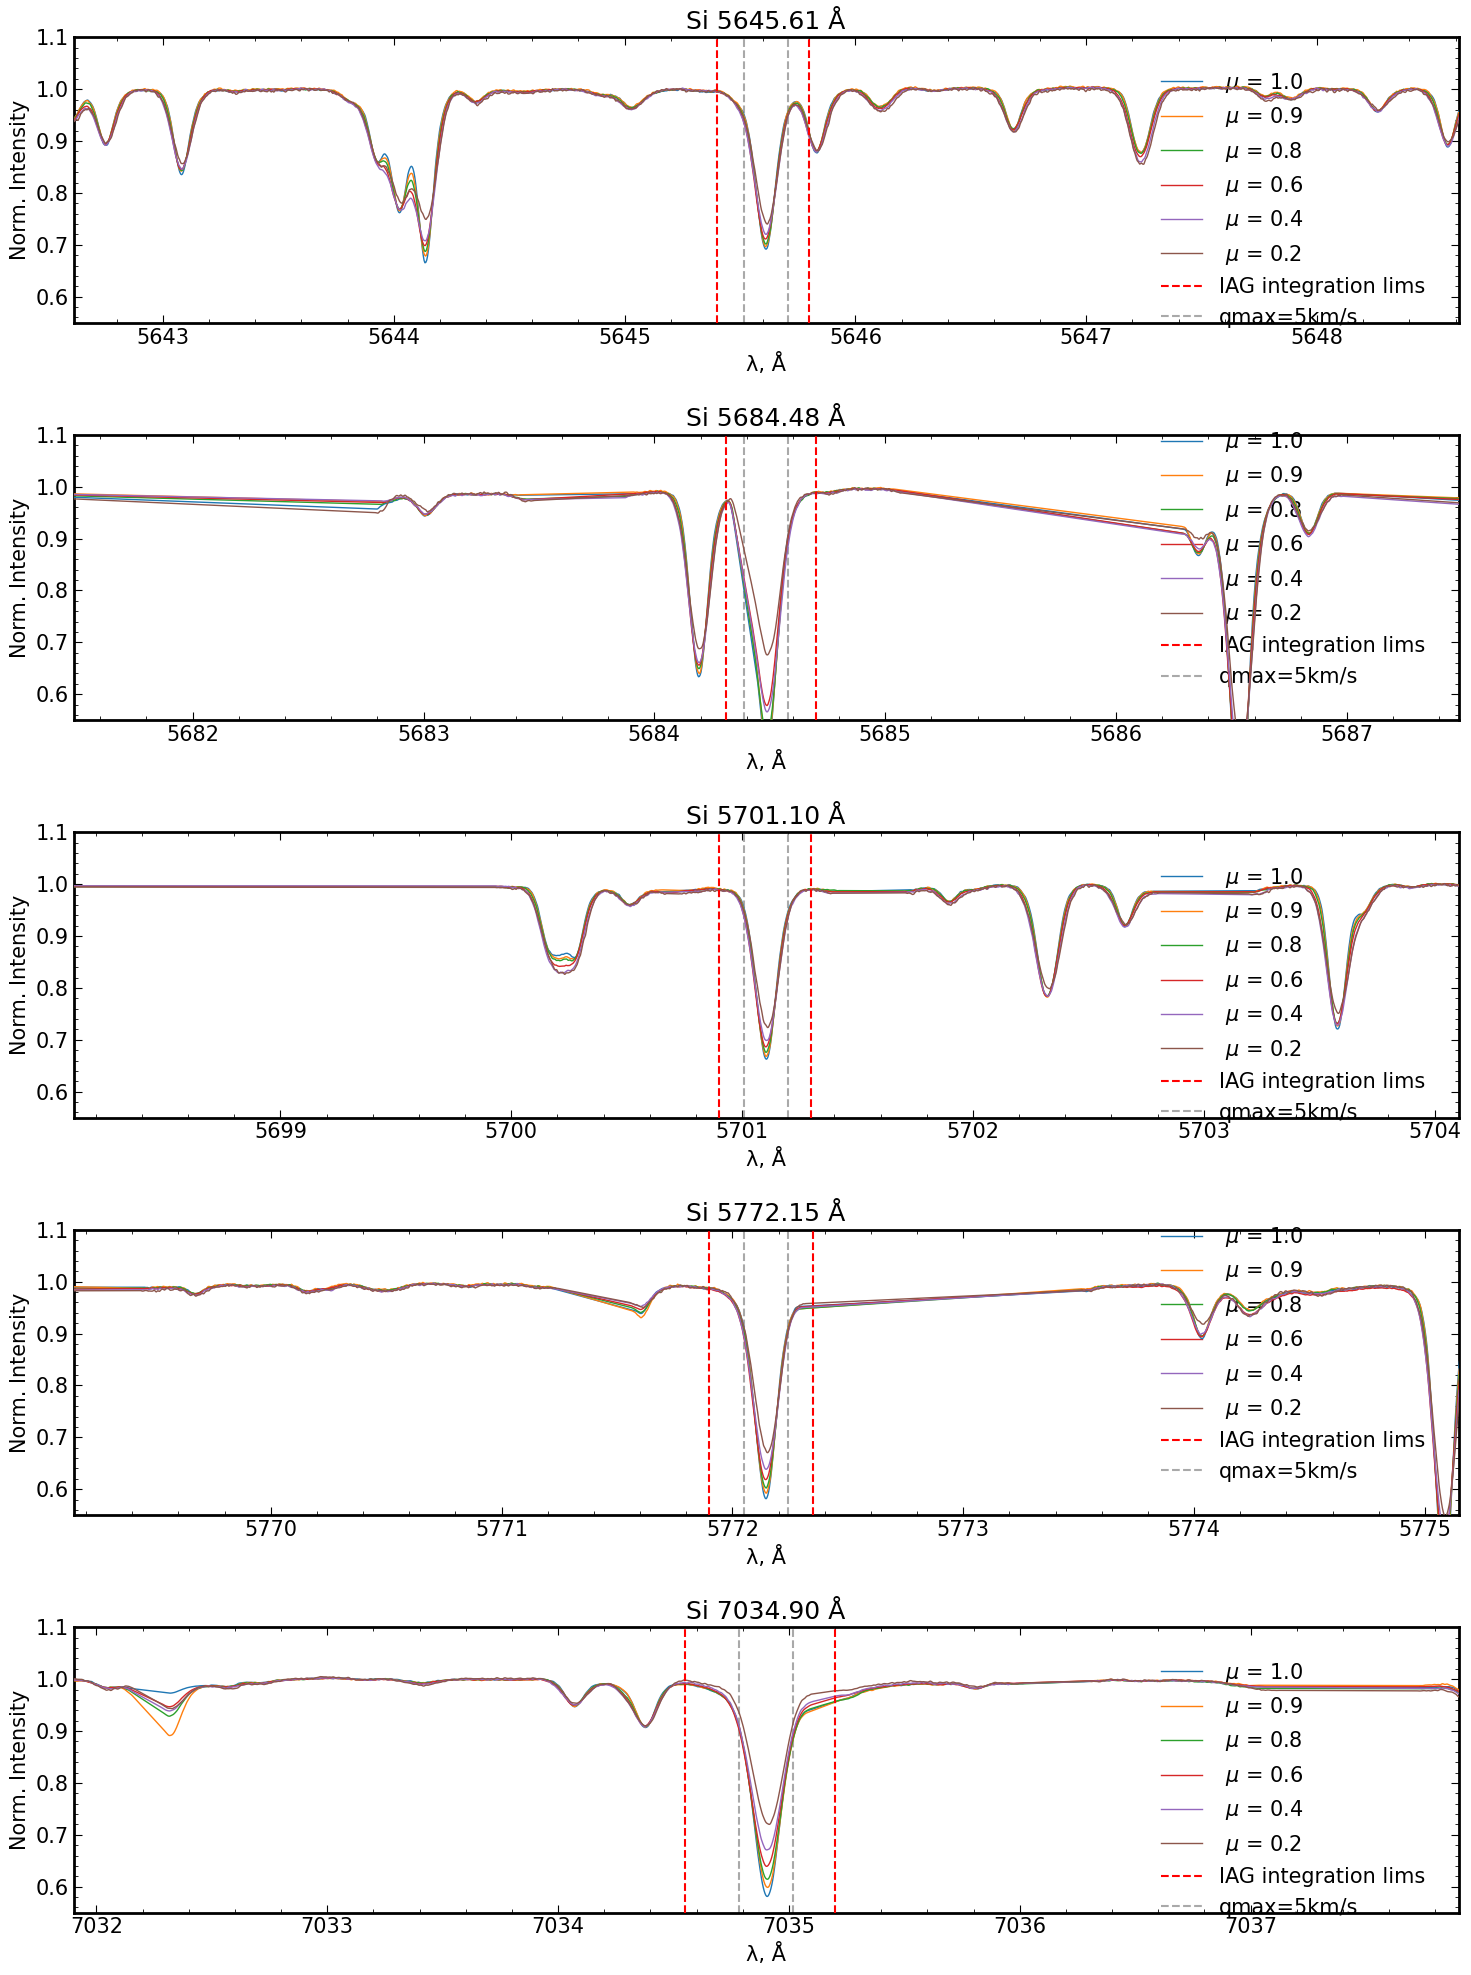

In [74]:
# Plot zoomed-out observed spectra 
fig, ax = plt.subplots(len(major_krs), 1, figsize=(15,20))

for i, thiskr in enumerate(major_krs):
    
    for j, thismu in enumerate(sol_mus):
        # plt.sca(ax[j])
        ax[i].plot(sol_lams[j], sol_fluxes[j], zorder=100, label=rf' $\mu$ = {sol_mus[j]:.1f}', linewidth=1)#,markersize=4)


    # plot picked integration limits 
    for lim in iag_int_lims[i,:]:
        ax[i].axvline(lim, color='r', linestyle='--', label = 'IAG integration lims', zorder=200)

    for lim in max_int_lims[i,:]:
        ax[i].axvline(lim, color='darkgrey', linestyle='--', label=f'qmax={sim_qmax}km/s')
    # ax[i].grid(axis='y')

    ax[i].set_title(f'Si {m3d_centre_wavelengths[i]:.2f} Å')
    ax[i].set_ylabel('Norm. Intensity')
    ax[i].set_xlabel('λ, Å')

    plt.sca(ax[i])

    plt.xlim((m3d_centre_wavelengths[i]-3), (m3d_centre_wavelengths[i]+3))
    plt.ylim(0.55,1.1)    

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax[i].legend(by_label.values(), by_label.keys())
    # ax[i].legend(loc='best')
    

plt.tight_layout()
# fig.savefig('../plots/raw_iag_zoomedout.pdf')

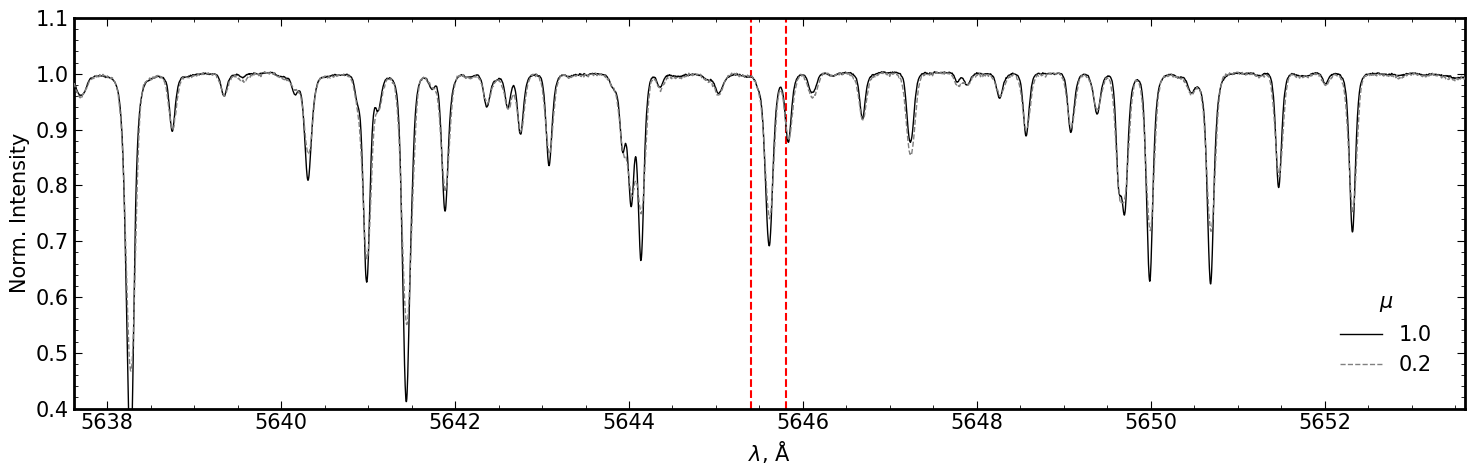

In [73]:
# Plot zoomed-out observed spectra 
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(1, figsize=(15,5))
i=0
thiskr=major_krs[0]
colors=['k','brown','darkgreen','darkblue', 'purple', 'gray']
styles=['-','-','-','-','-','--']

for j, thismu in enumerate(sol_mus):
    # plt.sca(ax[j])
    if j == 0 or j == 5:
        ax.plot(sol_lams[j], sol_fluxes[j], zorder=100, label=sol_mus[j], linewidth=1, color=colors[j],linestyle=styles[j])#,markersize=4)


# plot picked integration limits 
for lim in iag_int_lims[i,:]:
    ax.axvline(lim, color='r', linestyle='--')
# ax[i].grid(axis='y')

# ax.set_title(f'Si {m3d_centre_wavelengths[i]:.2f} Å')
ax.set_ylabel('Norm. Intensity')
ax.set_xlabel(r'$\lambda$, Å')

plt.sca(ax)

plt.xlim((m3d_centre_wavelengths[i]-8), (m3d_centre_wavelengths[i]+8))
plt.ylim(0.4,1.1)    
ax.legend(title='$\mu$', loc='lower right')


plt.tight_layout()
# plt.savefig('../plots/zoomoutspec.png')

## Deblending, renormalising lines in observed spectra

In [35]:
from scipy.signal import argrelextrema
from scipy.special import voigt_profile
from scipy import optimize

def synth_blends(obs_xx, obs_yy, order=20, blank_lam=None):
    exts = np.array(argrelextrema(obs_yy, np.less, order=order))[0]
    
    pn=5
    def model_func(xdata, *args):
        yy_pred = np.ones_like(xdata)
        
        for i, gamma in enumerate(args[::pn]):
            sigma = args[1::pn][i]
            scale = args[2::pn][i]
            shift = args[3::pn][i]
            skew  = args[4::pn][i]
            ext = exts[i]
            
            sxx = xdata - xdata[ext] + shift
            voigt = voigt_profile(sxx, sigma, gamma)
            
            sk_xx = sxx+np.abs(sxx)*skew
            sk_voigt = np.interp(sxx, sk_xx, voigt)
            
            yy_pred -= sk_voigt / np.max(sk_voigt) * (1-obs_yy[ext]) * scale
            
        return yy_pred
    
    params = np.ones(exts.size*pn)*1e-2
    params[2::pn] = 1
    params[3::pn] = 0
    params[4::pn] = 0
    
    pfit, pcov = optimize.curve_fit(model_func, obs_xx, obs_yy, p0=params)
    
    if blank_lam is not None:
        pfit_blank = pfit.copy()
        iline = np.where(obs_xx[exts] > blank_lam)[0][0]
        pfit_blank[pn*iline+2] = 0
        
        yy = model_func(obs_xx, *pfit_blank)
        
    else:
        yy = model_func(obs_xx, pfit)
    
    return yy

In [65]:
line_0_eqw = []
line_0_int = []
for j, mu in enumerate(sol_mus):
    xx = sol_lams[j]
    yy = sol_fluxes[j]

    lam0 = m3d_centre_wavelengths[0]
    mask = np.abs(xx - lam0) < 0.4
    xx = xx[mask]
    yy = yy[mask]
        

    thislam0 = xx[np.argmin(yy)]
    yy_blend = synth_blends(xx, yy, order=25, blank_lam=0)
    # save the blend profile for plotting, for just the first mu
    if mu==1:
        yy_blend_mu1_line0 = yy_blend
        yy_mu1_line0 = yy
        xx_blend_mu1_line0 = xx

    
    yy_deblend = 1 - ((1-yy) - (1-yy_blend))

    line_0_eqw.append(integrate.simps(y=1-yy_deblend, x=xx) * 1000)
    line_0_int.append(yy_deblend)

    # overwrite lambda/int range for this line 
    sol_lam_range_list[0,j] = xx
    sol_int_range_list[0,j] = yy_deblend

    ## test another deblend
    thislam0 = xx[np.argmin(yy_deblend)]
    yy_blend2= synth_blends(xx, yy_deblend, order=25, blank_lam=0)
    yy_deblend2 = 1 - ((1-yy_deblend) - (1-yy_blend2))
    if mu==1:
        yy_blend2_mu1_line0 = yy_blend2
        yy2_mu1_line0 = yy


In [67]:
line_0_eqw

[38.4792439070085,
 38.20488721152662,
 39.11328849589615,
 39.47000022694908,
 39.2433997449074,
 36.69193391554826]

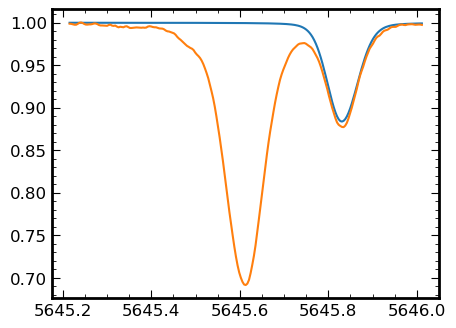

In [66]:
plt.plot(xx_blend_mu1_line0, yy_blend_mu1_line0)
plt.plot(xx_blend_mu1_line0, yy_mu1_line0)
# plt.plot(xx_blend_mu1_line0, yy_blend2_mu1_line0)

In [37]:
# sim_int_1d = get_ang_intensity(runobjects[0], kr=major_krs[line_ind])
# sim_int_1d_norm = sim_int_1d/continuum(line_lam, np.array(sim_int_1d))

# define continuum at the chosen integration limits for each line
# renorm_lines_indx = [3,4]
sol_int_renorm = np.zeros((len(major_krs), len(sol_mu_ind)), dtype=object)

for i, line in enumerate(major_krs):
    for j, mu in enumerate(sol_mus):
        sol_int_renorm[i,j] = sol_int_range_list[i,j]/continuum(sol_lam_range_list[i,j], sol_int_range_list[i,j])

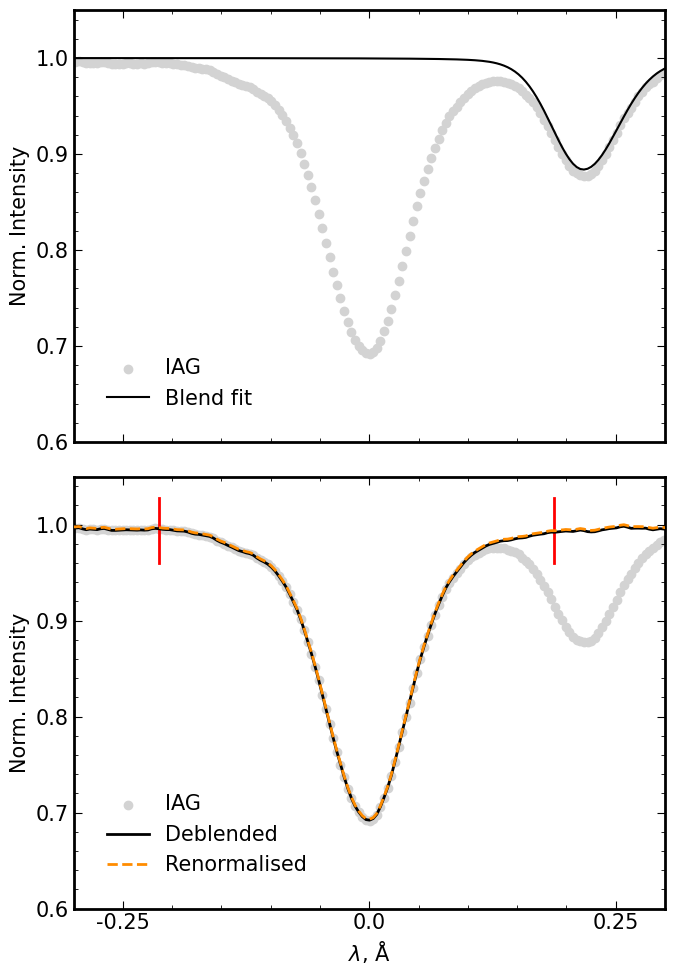

In [38]:
# plot one line at one angle with the raw, deblended and renormalised profiles

# Plot zoomed-out observed spectra 
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(2,1, figsize=(7,10), sharex=True)
i=0
thiskr=major_krs[0]
# colors=['k','brown','darkgreen','darkblue', 'purple', 'gray']
# styles=['-','-','-','-','-','--']
j=0
thismu = sol_mus[0]

# plot one
# raw
ax[0].scatter(sol_lams[j], sol_fluxes[j], zorder=0, label='IAG', color='lightgray')
ax[0].plot(xx_blend_mu1_line0, yy_blend_mu1_line0, label='Blend fit', color='k')



# plot two
# raw
ax[1].scatter(sol_lams[j], sol_fluxes[j], zorder=0, label='IAG', color='lightgray')#, color=colors[j],linestyle=styles[j])#,markersize=4)
# deblended
ax[1].plot(sol_lam_range_list[0,j], sol_int_range_list[0,j], label='Deblended', color='k', linestyle='-',zorder=10, linewidth=2)
ax[1].plot(sol_lam_range_list[0,j],sol_int_renorm[0,j], label='Renormalised', color='darkorange', linestyle='--',zorder=100, linewidth=2)

# plot picked integration limits 
for lim in iag_int_lims[i,:]:
    ax[1].axvline(lim, ymin=0.8, ymax=0.95, color='red', linestyle='-', linewidth=2)
# ax[i].grid(axis='y')

# ax.set_title(f'Si {m3d_centre_wavelengths[i]:.2f} Å')
ax[0].set_ylabel('Norm. Intensity')
ax[1].set_ylabel('Norm. Intensity')
ax[1].set_xlabel(r'$\lambda$, Å')


ax[0].set_xlim((m3d_centre_wavelengths[i]-0.3), (m3d_centre_wavelengths[i]+0.3))
ax[0].set_ylim(0.6,1.05)
ax[1].set_ylim(0.6,1.05)    
ax[1].set_xticks(ticks=np.linspace(m3d_centre_wavelengths[j]-0.25, m3d_centre_wavelengths[j]+0.25,3) ,labels=np.linspace(-0.25,0.25,3))
ax[0].legend()
ax[1].legend()


plt.tight_layout()
# plt.savefig('../plots/iagprocessingex.png')

## Plot to show EW

(0.0, 1.05)

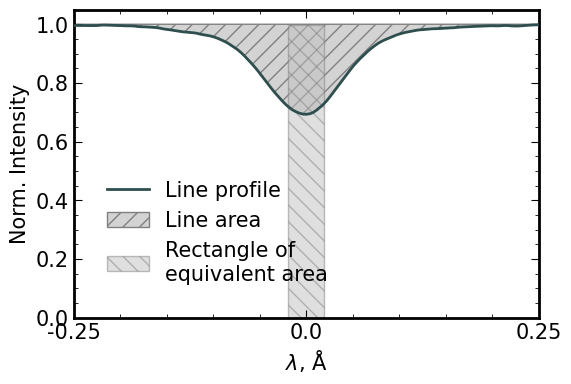

In [39]:
plotEW = line_0_eqw[0]/1000
ew_low = m3d_centre_wavelengths[0] - plotEW/2
ew_high = m3d_centre_wavelengths[0] + plotEW/2
fig, ax = plt.subplots(1,1, figsize=(6,4), sharex=True)
j=0
ax.plot(sol_lam_range_list[0,j],sol_int_renorm[0,j], label='Line profile', color='darkslategray', linestyle='-',zorder=100, linewidth=2)
ax.fill_between(sol_lam_range_list[0,j], 1,sol_int_renorm[0,j], edgecolor='gray', label='Line area', hatch='//', facecolor='lightgray')
ax.axvspan(ew_low, ew_high, edgecolor='gray', ymax=0.95, label='Rectangle of \nequivalent area',hatch='\\\\', facecolor='silver', alpha=0.5)
ax.set_xlim((m3d_centre_wavelengths[0]-0.25), (m3d_centre_wavelengths[0]+0.25))
ax.set_xticks(ticks=np.linspace(m3d_centre_wavelengths[j]-0.25, m3d_centre_wavelengths[j]+0.25,3) ,labels=np.linspace(-0.25,0.25,3))
ax.set_ylabel('Norm. Intensity')
ax.set_xlabel(r'$\lambda$, Å')
ax.legend()
ax.set_ylim(0,1.05)
# fig.savefig('../plots/ew_diagram.png')


In [40]:
# replot with new normalisation
plot=False
if plot==True:
    fig, ax = plt.subplots(len(major_krs), 1, figsize=(13,20))

    for i, line_i in enumerate(major_krs):
        
        for j, thismu in enumerate(sol_mus):
            # plt.sca(ax[j])
            ax[i].scatter(sol_lam_range_list[i,j], sol_int_renorm[i,j], zorder=100, label=sol_mus[j])
            # ax[i].plot(sol_lam_range_list[i,j], sol_int_range_list[i,j], linestyle='none', marker='.', zorder=100, label=sol_mus[j],markersize=4)


        # plot picked integration limits 
        for lim in iag_int_lims[i,:]:
            ax[i].axvline(lim)
        ax[i].grid(axis='y')

        ax[i].set_title(f'Si {m3d_centre_wavelengths[i]:.2f} Å')
        ax[i].set_ylabel('Norm. Intensity')
        ax[i].set_xlabel('λ, Å')

        plt.sca(ax[i])

        plt.xlim((m3d_centre_wavelengths[i]-0.25), (m3d_centre_wavelengths[i]+0.25))
        
        plt.ylim(0.4,1.1)    
        ax[i].legend()

    plt.tight_layout()

In [41]:
# # # save processed spectrum intensities and wavelength range
# with open('../mdata/sol_int_renorm', 'wb') as f:
#     pickle.dump(sol_int_renorm, f)

# with open('../mdata/sol_lam_range_list', 'wb') as f:
#     pickle.dump(sol_lam_range_list, f)

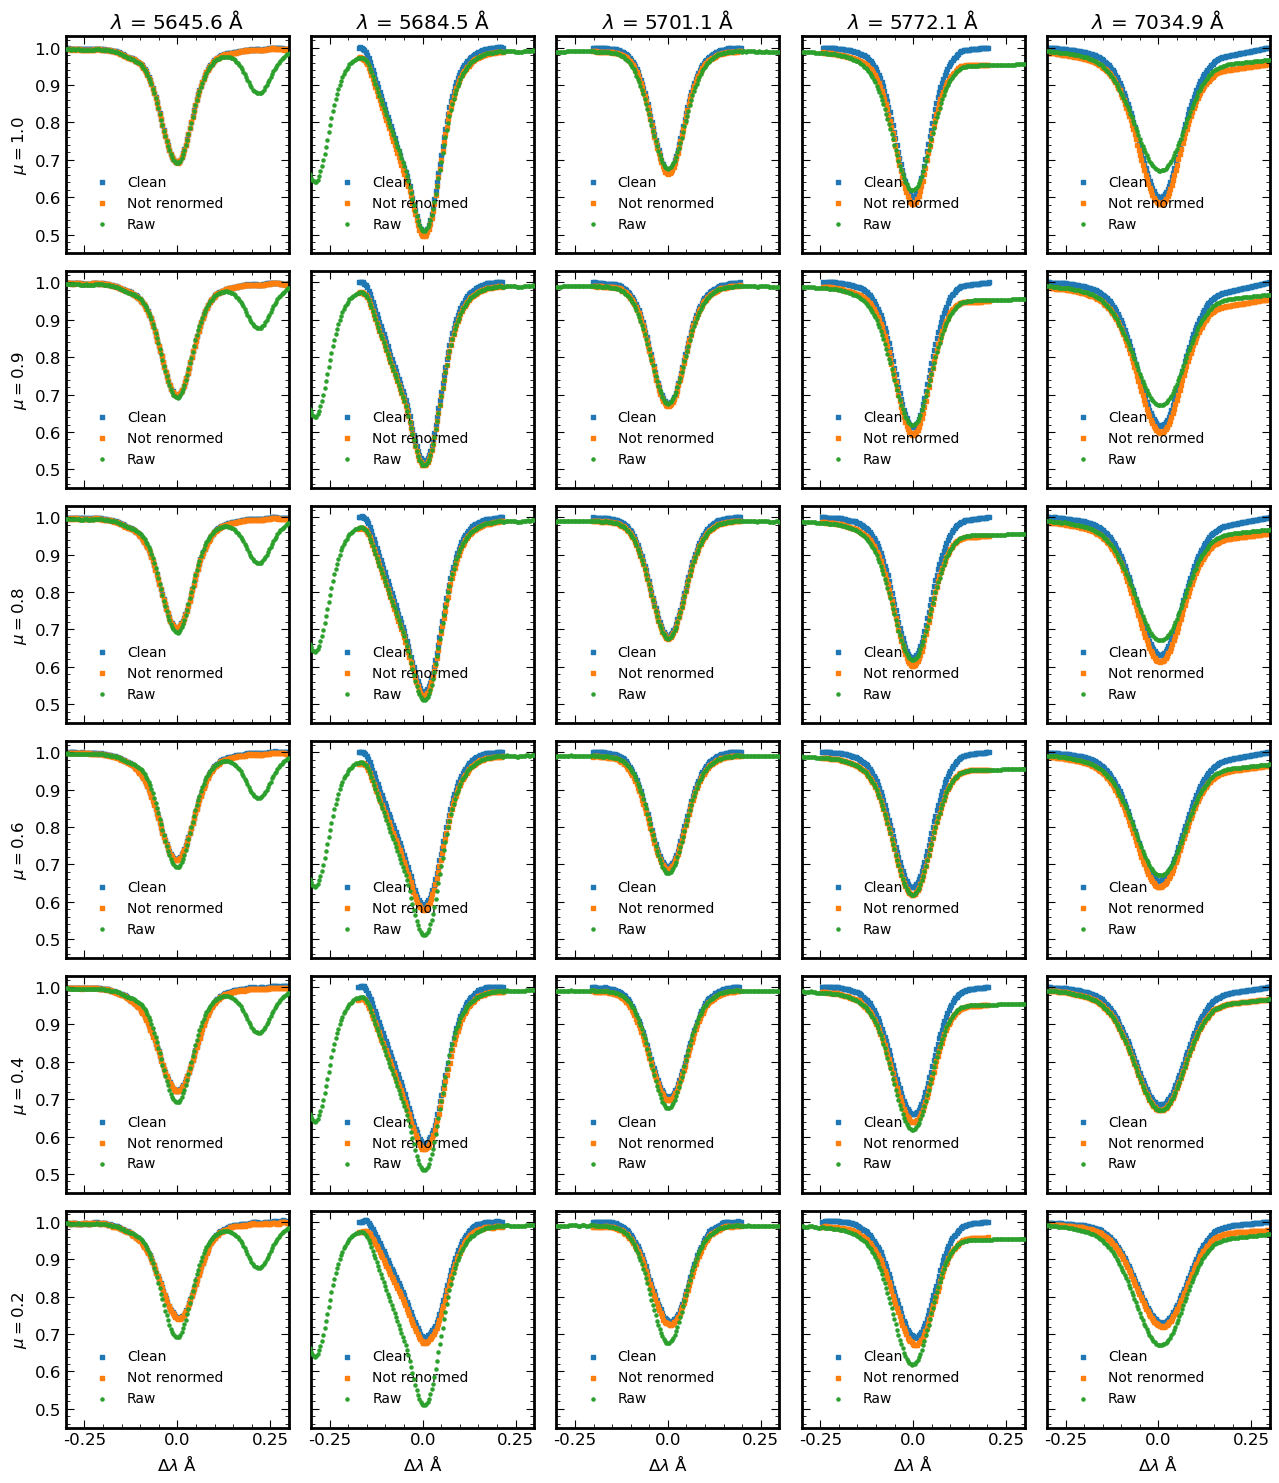

In [42]:
# plot line profiles with before and after normalisation
plot=True
if plot==True:
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(len(sol_mus), len(major_krs), figsize=(13,15), sharex='col', sharey='row')

    for i, thismu in enumerate(sol_mus):
        for j, line_i in enumerate(major_krs):

            # plt.sca(ax[j])
            ax[i,j].scatter(sol_lam_range_list[j,i], sol_int_renorm[j,i],  label='Clean', marker='s', s=10)
            ax[i,j].scatter(sol_lam_range_list[j,i], sol_int_range_list[j,i],  label='Not renormed', marker='s', s=10)

            ax[i,j].scatter(sol_lams[j], sol_fluxes[j], label='Raw', zorder=100,marker='.', s=20)
            
            # ax[i].plot(sol_lam_range_list[i,j], sol_int_range_list[i,j], linestyle='none', marker='.', zorder=100, label=sol_mus[j],markersize=4)
            ax[i,j].set_xlim((m3d_centre_wavelengths[j]-0.3), (m3d_centre_wavelengths[j]+0.3))
            ax[i,j].set_xticks(ticks=np.linspace(m3d_centre_wavelengths[j]-0.25, m3d_centre_wavelengths[j]+0.25,3) ,labels=np.linspace(-0.25,0.25,3))
            
            ax[i,j].legend(fontsize='small')
            plt.sca(ax[i,j])
            # print((ax[i,j].get_xticks(), 'i'))

            plt.ylim(0.45,1.03) 
            # plt.ticklabel_format(style='plain', axis='x', useOffset=(m3d_centre_wavelengths[j]-0.3))
            if i == 0:
                ax[i,j].set_title(f'$\lambda$ = {m3d_centre_wavelengths[j]:.1f} Å')
            if i == len(sol_mus)-1:
                ax[i,j].set_xlabel('$\Delta \lambda$ Å')
            if j == 0:
                ax[i,j].set_ylabel(f'$\mu = {thismu:.1f}$')
        
       
    
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)

In [43]:
#  recalculate equivalent widths
new_eq_iag = np.zeros(eq_iag.shape)
for i, line_i in enumerate(major_krs):
    for j, thismu in enumerate(sol_mus):
            new_eq_iag[i,j] = integrate.simps(y=1-sol_int_renorm[i,j], x=sol_lam_range_list[i,j]) * 1000

In [44]:
new_eq_iag[2,0]

37.39984711292819

37.39984711292819
40.79230605100446


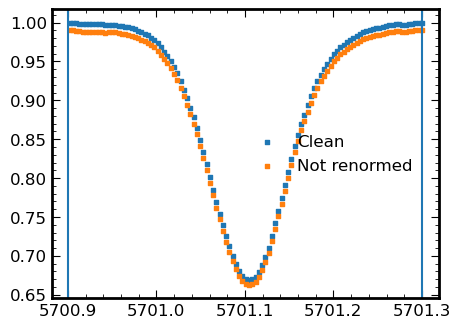

In [45]:
thiskr = j = 2
thismu = i = 0

fig, ax = plt.subplots(1, 1,)
ax.scatter(sol_lam_range_list[j,i], sol_int_renorm[j,i],  label='Clean', marker='s', s=10)
ax.scatter(sol_lam_range_list[j,i], sol_int_range_list[j,i],  label='Not renormed', marker='s', s=10)
for lim in iag_int_lims[j,:]:
    ax.axvline(lim)
plt.legend()
# ax.scatter(sol_lams[j], sol_fluxes[j], label='Raw', zorder=100,marker='.', s=20)
print(integrate.simps(y=1-sol_int_renorm[j,i], x=sol_lam_range_list[j,i]) * 1000)
print(integrate.simps(y=1-sol_int_range_list[j,i], x=sol_lam_range_list[j,i]) * 1000)


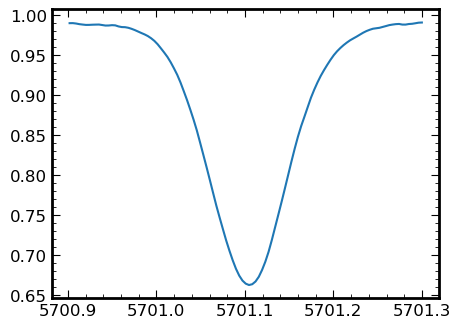

In [46]:
plt.plot(sol_lam_range_list[2,0], sol_int_range_list[2,0])

In [47]:
# with open('../mdata/new_eq_iag', 'wb') as f:
#     pickle.dump(new_eq_iag, f)

In [48]:
"\N{Sauropod}"

'🦕'

In [49]:
new_eq_iag

array([[37.39052164, 37.70652409, 37.78296948, 37.4957929 , 37.48513149,
        35.15446423],
       [68.28468401, 66.34396401, 66.15151412, 59.53527118, 62.02537092,
        44.62993976],
       [37.39984711, 38.28876381, 38.03009964, 37.97879403, 38.10009222,
        34.05126862],
       [48.05421058, 47.5844428 , 48.04921485, 48.09399165, 46.60470836,
        41.84336932],
       [65.05146979, 63.83043483, 62.57093773, 60.9827351 , 56.49767367,
        47.38151637]])